## Makemore pt3

In [2]:
import torch

In [3]:
import torch.nn.functional as F

In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
words = open("names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [7]:
len(words)

32033

In [8]:
# build vocab and mappings
chars = sorted(list(set(''.join(words))))
itos = {i+1:c for i,c in enumerate(chars)}
itos[0] = "."
stoi = {c:i for i,c in itos.items()}
vocab_size = len(stoi)
vocab_size

27

In [9]:
# build dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)

    return X, Y
            

In [35]:
# data splits
import random
random.seed(42)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

random.shuffle(words)


Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [79]:
# MLP revisited
n_embd = 10 # dimension of the characters embeddings
neurons_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),                       generator = g)
W1 = torch.randn((n_embd * block_size, neurons_hidden),     generator = g) 
b1 = torch.randn(neurons_hidden,                            generator = g) * 0.01
W2 = torch.randn((neurons_hidden, vocab_size),              generator = g) * 0.01
b2 = torch.randn(vocab_size,                                generator = g) * 0

parameters = [C, W1, b1, W2, b2]

print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

Number of parameters: 11897


In [80]:
# optimization
max_steps = 200000
batch_size = 32
lossi = list()

for i in range(max_steps):

    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    h = torch.tanh(emb.view(-1, block_size * n_embd) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # gradient
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if (i % 10000) == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())
    break



      0/ 200000: 3.319430


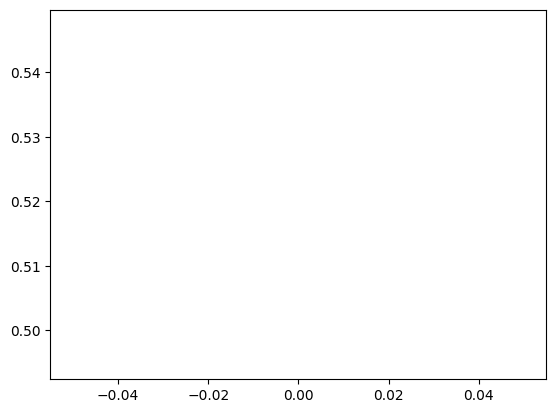

In [81]:
plt.plot(lossi)

In [76]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1332297325134277
val 2.1759681701660156


In [77]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10 )

num_names = 21
for _ in range(num_names):
    out = list()
    context = [0] * block_size
    while True:
        # forward pass
        emb = C[context]
        h = torch.tanh(emb.view(-1, block_size * n_embd) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()

        # shift context window
        context = context[1:] + [ix]

        # update new character
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmahzati.
hari.
kimrisheely.
saley.
kenrahnee.
den.
art.
kaeli.
ner.
kiah.
maiir.
kaleigh.
ham.
join.
quinn.
sulin.
aliven.
kiraelo.
dearyxi.
jayek.
dus.


In [17]:
emb.view(1, -1)

tensor([[-0.2129,  0.5092,  0.3269,  1.9661, -0.2412, -0.7950,  0.2722, -1.1102,
         -0.4530, -0.4961, -1.0726,  0.7277,  0.0509,  1.3094, -0.8022, -0.8501,
         -1.8066,  1.2524, -1.2258,  1.2165, -1.3257,  0.1466,  0.1698, -1.5397,
         -0.7273,  1.1491, -0.8747, -0.2980, -1.3710,  0.1151]],
       grad_fn=<ViewBackward0>)

In [18]:
emb.view(emb.shape[0], -1).shape

torch.Size([3, 10])

In [19]:
emb.shape

torch.Size([3, 10])

## Problems with our previous implementation

### Fixing the initial loss
The first item of the loss is too high and then it stabilizes. That causes the loss plot to look like a hockey stick which gauges that the model is learning the bias only in the first iterations. 
- **Cause:** A poor initialization of the last layers wandb
- **Solution:** Scale `W1` by `0.01` and set `b2 = b2 * 0`

### Fixing saturated tanh
- If we see the values of `h` after the first iteration we see this
``` tensor([[-0.9620, -1.0000, -1.0000,  ..., -0.1601, -1.0000, -1.0000],
        [ 0.1131,  0.2711, -1.0000,  ..., -0.9979,  0.9930,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        ...,
        [-0.1424, -0.9988, -0.7355,  ..., -1.0000,  1.0000,  1.0000],
        [-0.9610,  0.7872, -0.9890,  ..., -1.0000,  0.9994,  1.0000],
        [-0.9620, -1.0000, -1.0000,  ..., -0.1601, -1.0000, -1.0000]],
       grad_fn=<TanhBackward0>)
```

- If wee see the values of `h` in a histogram we get this


(array([2154.,  161.,  104.,   67.,   60.,   52.,   39.,   36.,   25.,
          17.,   25.,   20.,   29.,   20.,   29.,   22.,   24.,    5.,
          24.,   18.,   20.,   16.,   10.,   21.,   23.,   26.,   15.,
          18.,   34.,   21.,   20.,   22.,   12.,   15.,   25.,   25.,
          43.,   29.,   43.,   38.,   32.,   36.,   41.,   36.,   49.,
          53.,   92.,  112.,  148., 2394.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

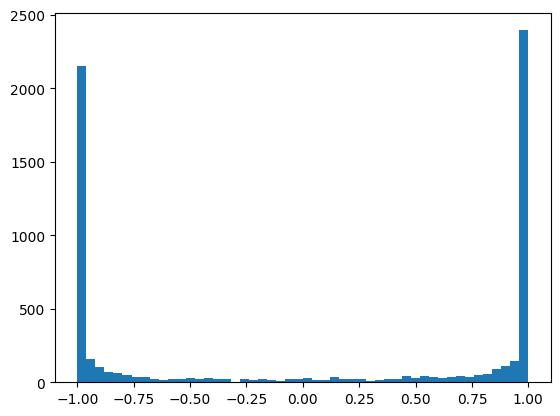

In [82]:
plt.hist(h.view(-1).tolist(), 50)

That histograms tells us that this `tanh` function is very active (extreme values are more frequent ones). We can see why is that seeing the preactivations of `h`

In [84]:
hpreact = emb.view(-1, block_size * n_embd) @ W1 + b1

(array([  3.,   2.,   1.,   2.,   2.,   1.,   6.,   8.,  14.,  27.,  35.,
         37.,  57.,  87., 120., 114., 133., 209., 222., 249., 282., 318.,
        363., 349., 325., 408., 381., 354., 342., 303., 259., 272., 247.,
        187., 126., 135., 124.,  91.,  55.,  33.,  28.,  26.,  17.,  16.,
          9.,   6.,   3.,   9.,   2.,   1.]),
 array([-19.29480553, -18.5281749 , -17.76154427, -16.99491364,
        -16.228283  , -15.46165237, -14.69502174, -13.92839111,
        -13.16176048, -12.39512985, -11.62849922, -10.86186859,
        -10.09523796,  -9.32860733,  -8.5619767 ,  -7.79534607,
         -7.02871544,  -6.26208481,  -5.49545418,  -4.72882355,
         -3.96219292,  -3.19556229,  -2.42893166,  -1.66230103,
         -0.89567039,  -0.12903976,   0.63759087,   1.4042215 ,
          2.17085213,   2.93748276,   3.70411339,   4.47074402,
          5.23737465,   6.00400528,   6.77063591,   7.53726654,
          8.30389717,   9.0705278 ,   9.83715843,  10.60378906,
         11.370419

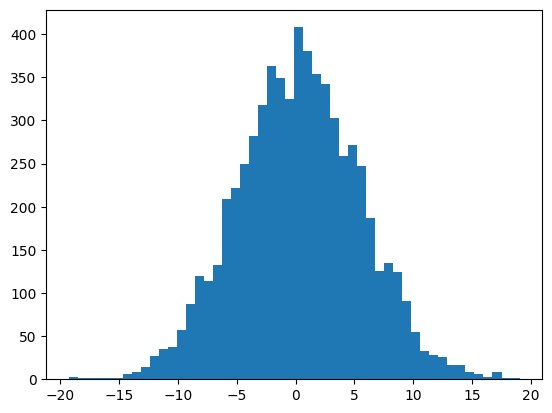

In [85]:
plt.hist(hpreact.view(-1).tolist(), 50)

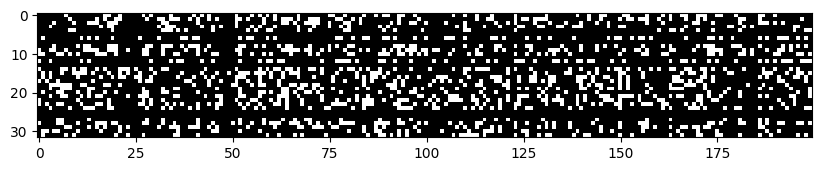

In [72]:
plt.figure(figsize=(10,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

The previous map shows the specific neurons that are saturating the activation function, tanh. 200 neurons and 32 logits (output). If we see a lot of white cells it means the model is not learning because information is lost in the activation.
- **Cause:** Initialization of `W1` and `b1` weights.
- **Solution:** Scaling initial weights by `0.01`

## Kaiming init
Kaiming He et al propose a method for initializing the initial weights using a factor that prevents data spreading or getting to narrow by keeping the standard deviation the same.
This is done by multiplying my $\text{std} = \frac{\text{gain}}{\sqrt{\text{fan\_in}}}$ where $\text{gain}$ is a related to the activation function (for tanh is 5/3); and $\text{fan\_in}$ is the number of input features in the model

`W1 = torch.randn((n_embd * block_size, neurons_hidden),     generator = g) * (5/3) / (n_embd * block_size)*1/2`

This is equivalent to using the `torch` function
```
torch.nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu', generator=None)
```

In [78]:
(5/3) / (n_embd * block_size)*1/2 # similar to what andrej suggested before

0.02777777777777778